Processing image: TestImages\StraightLineTest1.jpg


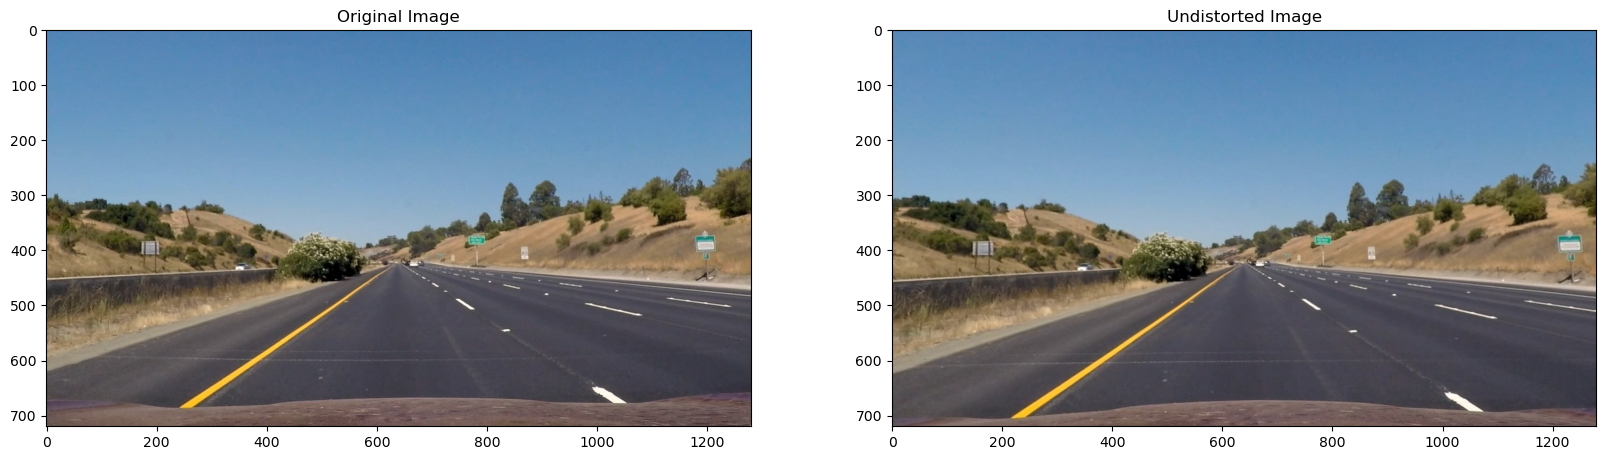

Processing image: TestImages\StraightLineTest2.jpg


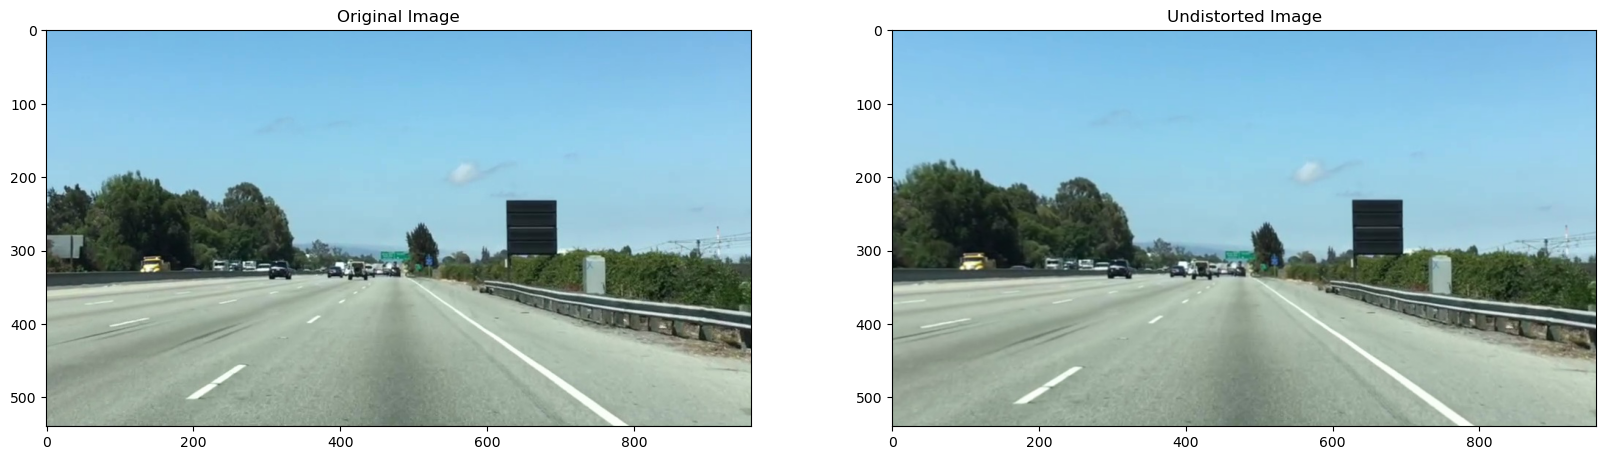

Processing image: TestImages\test1.jpg


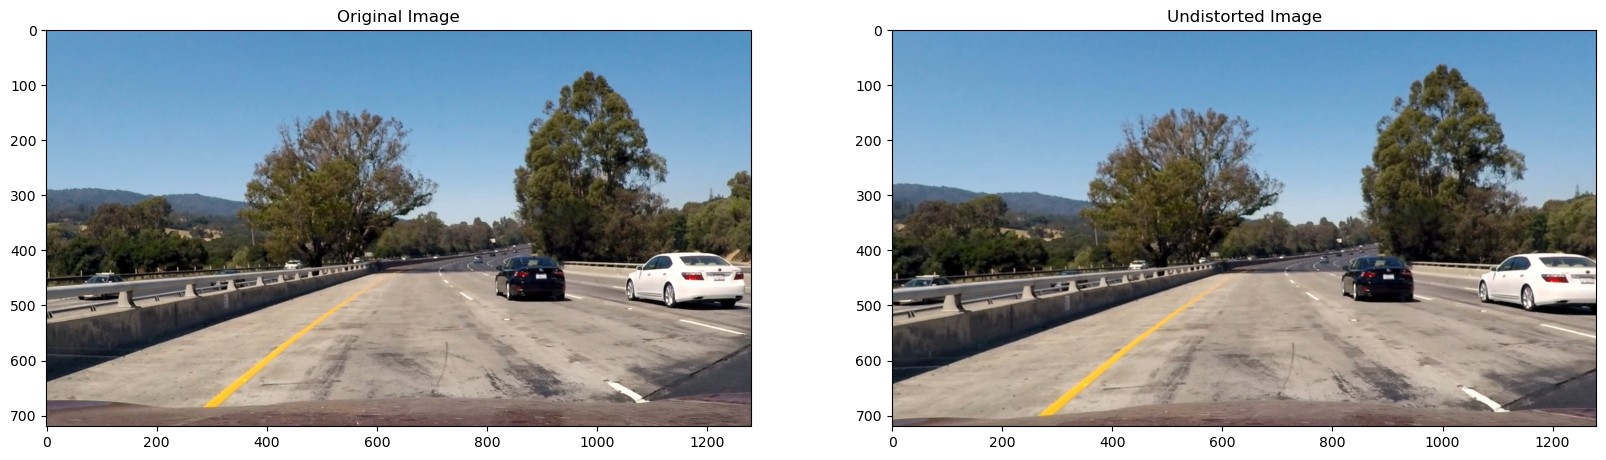

Processing image: TestImages\test2.jpg


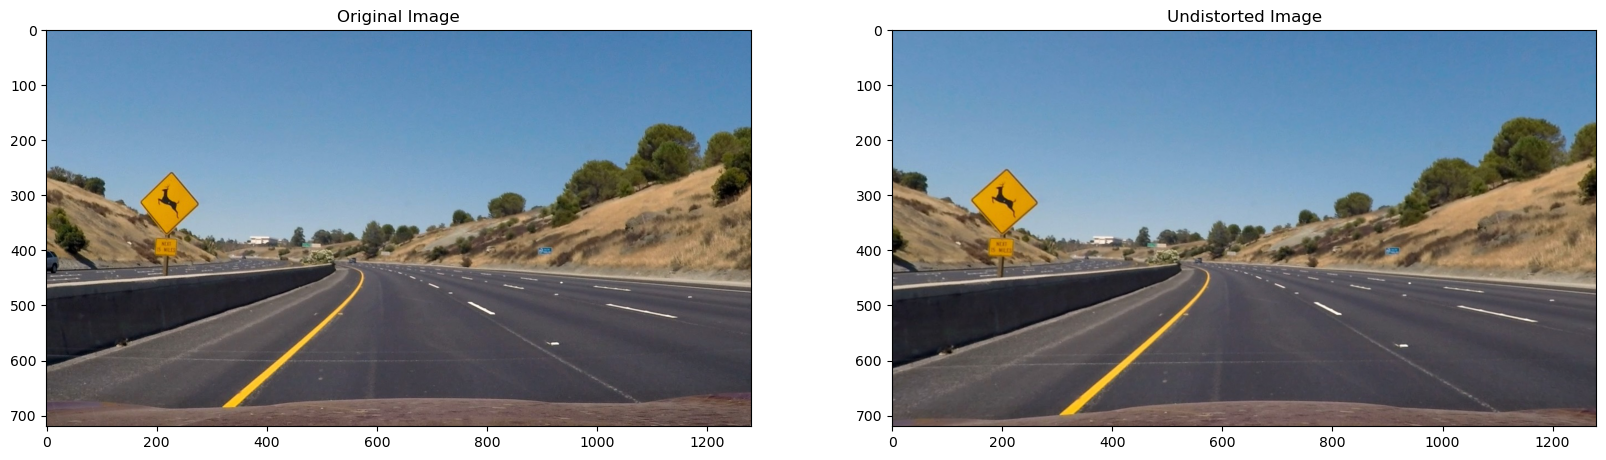

Processing image: TestImages\test3.jpg


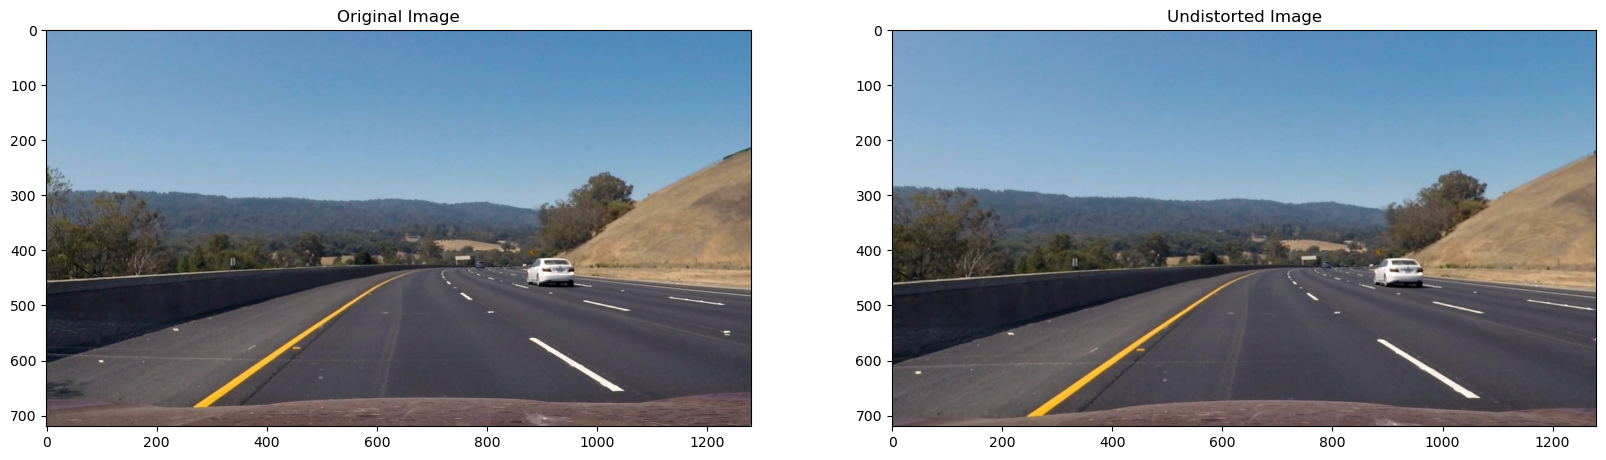

Processing image: TestImages\test4.jpg


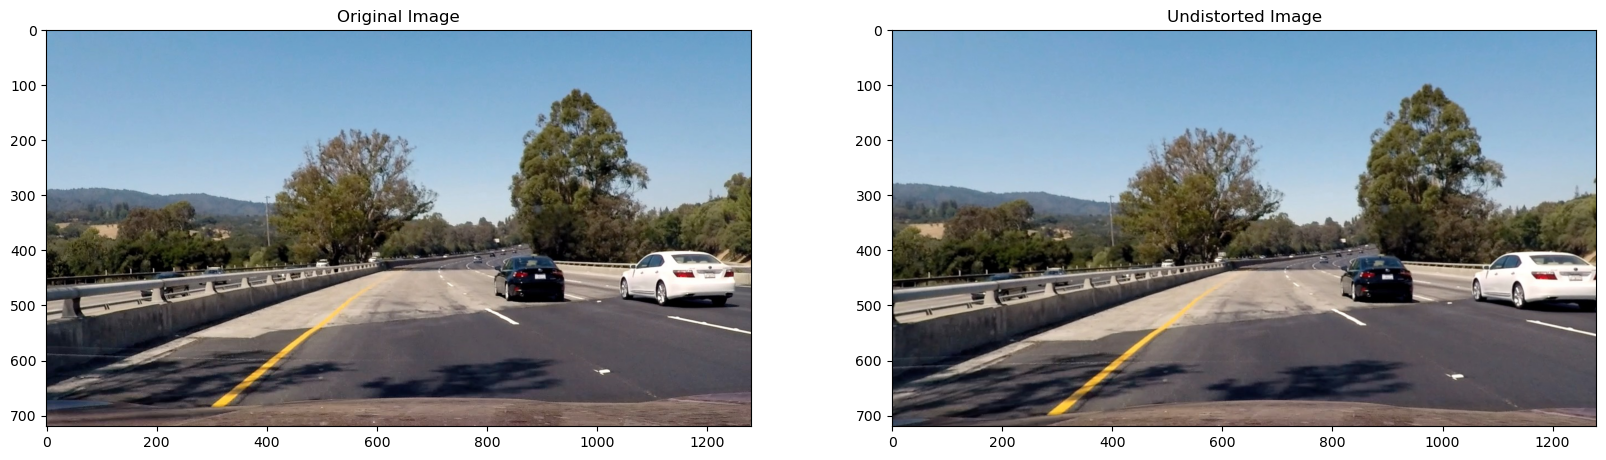

Processing image: TestImages\test5.jpg


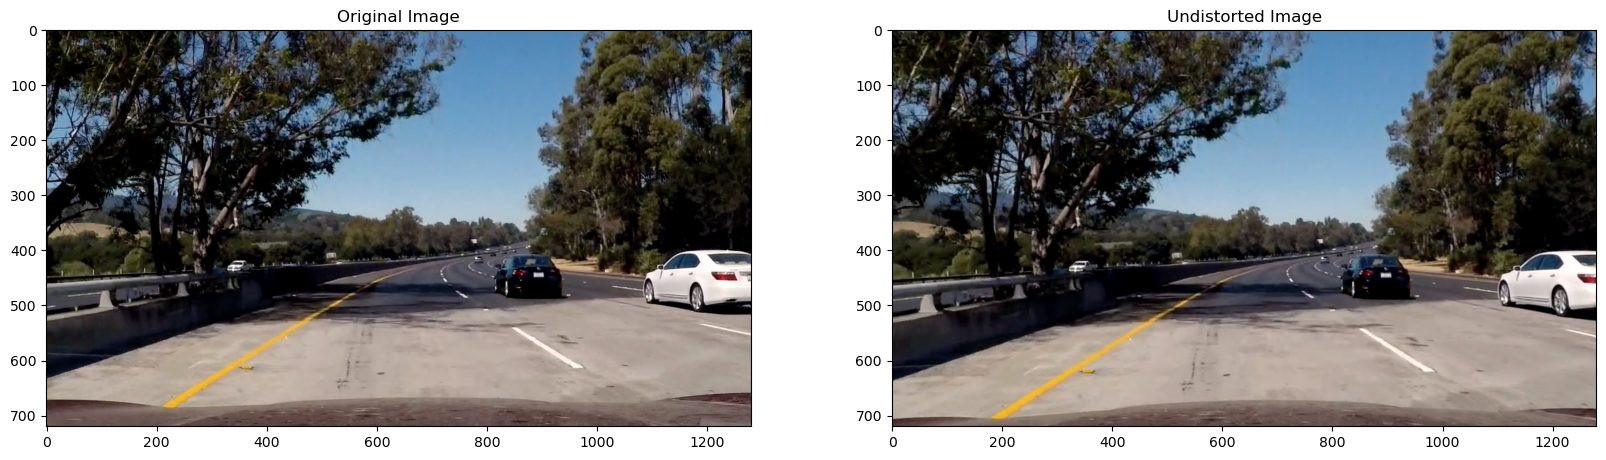

Processing image: TestImages\test6.jpg


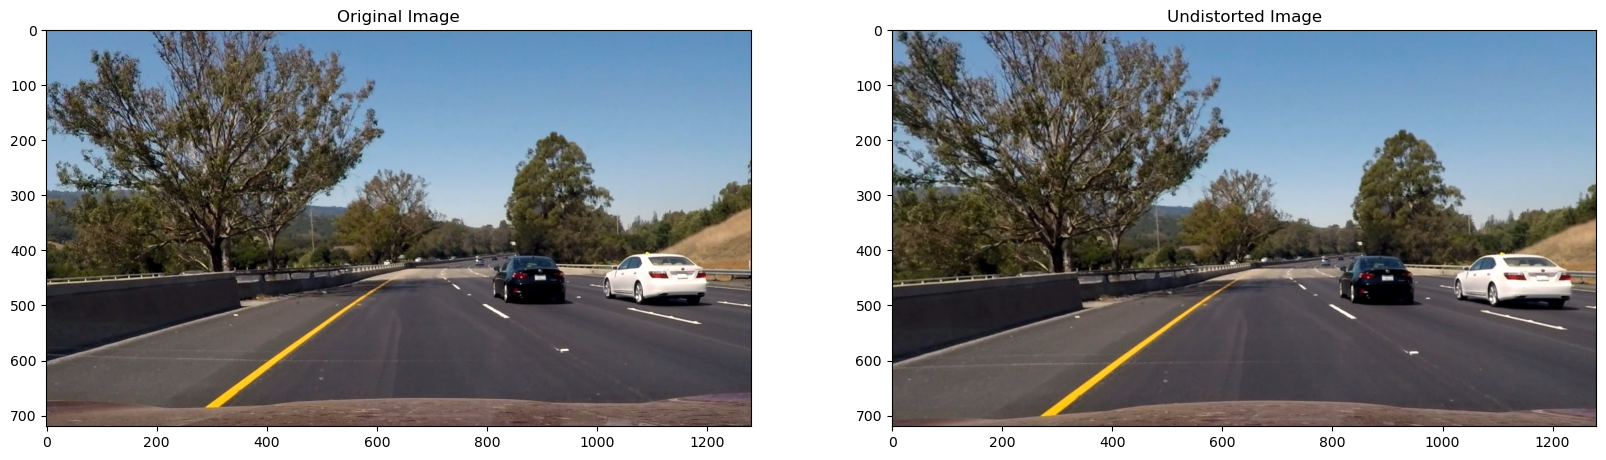

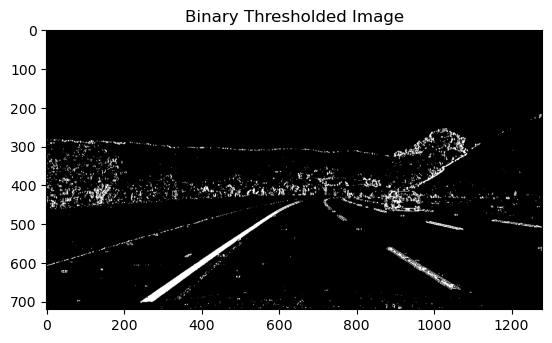

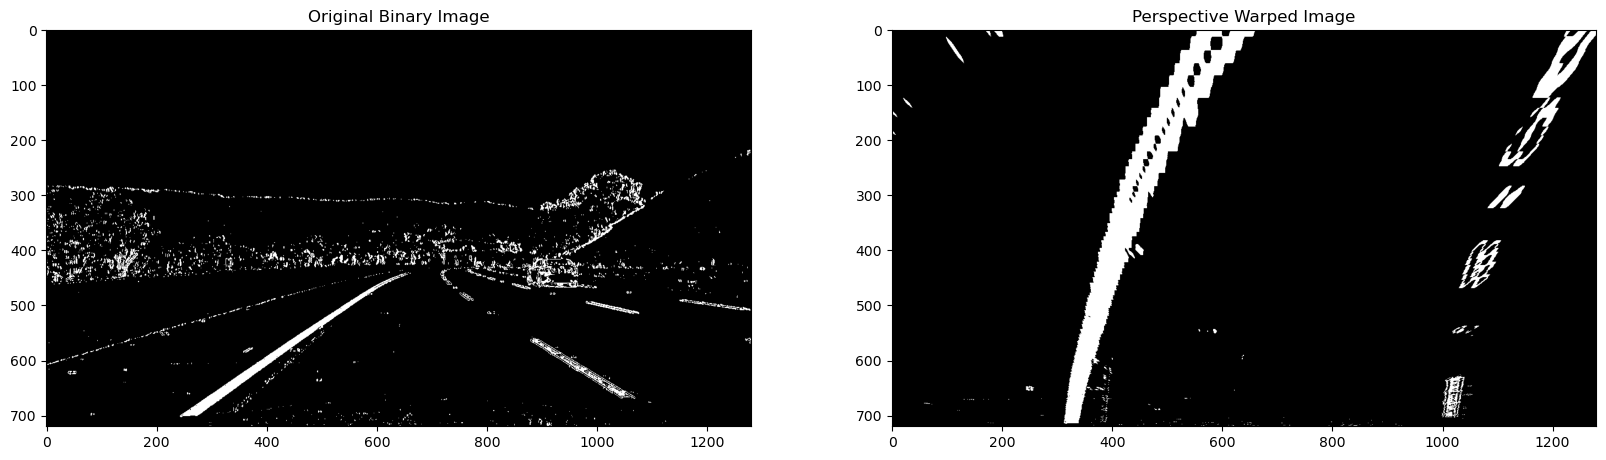

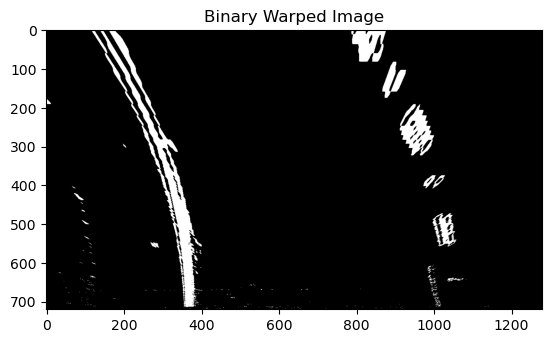

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


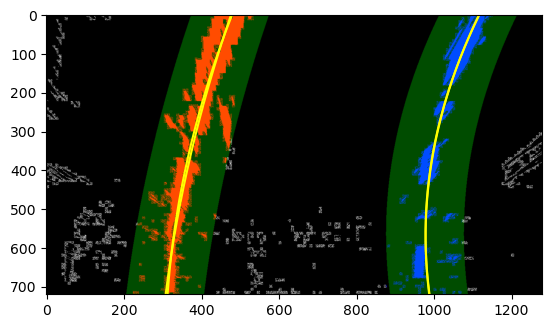

In [1]:
#Step 5: Detect Lane Pixels and Fit to Find Lane Boundaries

import numpy as np
import cv2
import matplotlib.pyplot as plt

#codes for image preprocessing
from DistortionCorrection import undistort_image
from ThresholdingAndPerspectiveTransform import abs_sobel_thresh
from ThresholdingAndPerspectiveTransform import combined_threshold
from ThresholdingAndPerspectiveTransform import color_threshold
from ThresholdingAndPerspectiveTransform import define_perspective_transform
from ThresholdingAndPerspectiveTransform import warp_perspective
from ThresholdingAndPerspectiveTransform import preprocess_image



#codes for lane fitting
from LaneFittingWithWindow import find_lane_pixels
from LaneFittingWithWindow import fit_polynomial
from LaneFittingFromPriorLane import fit_poly
from LaneFittingFromPriorLane import search_around_poly





In [2]:
# Load the camera calibration data
calibration_data = np.load('calibration_data.npz')
camera_matrix = calibration_data['camera_matrix']
dist_coeffs = calibration_data['dist_coeffs']

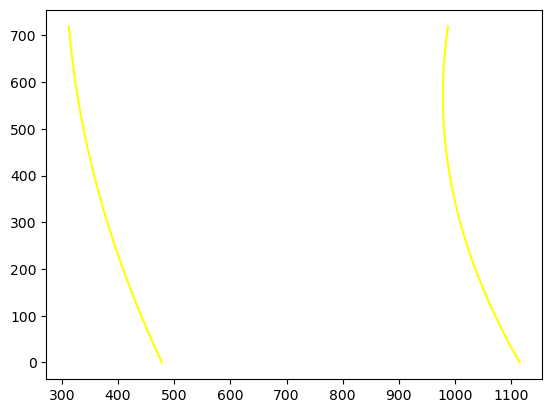

In [3]:
# Example usage
binary_warped = cv2.imread('warped-example.jpg', cv2.IMREAD_GRAYSCALE)  # Ensure the image is binary

lane_pixels = find_lane_pixels(binary_warped)
laneFit = fit_polynomial(binary_warped)



In [4]:
def draw_lane(binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    plot_y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    right_fitx = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]
    
    # Create an image to draw the lanes
    lane_img = np.zeros_like(binary_warped)
    
    # Fill the left and right lanes
    pts_left = np.vstack((left_fitx, plot_y)).astype(np.int32).T
    pts_right = np.vstack((right_fitx, plot_y)).astype(np.int32).T
    pts = np.hstack((pts_left, pts_right[::-1])).reshape((-1, 1, 2))
    cv2.fillPoly(lane_img, [pts], (0, 255, 0))
    
    return lane_img

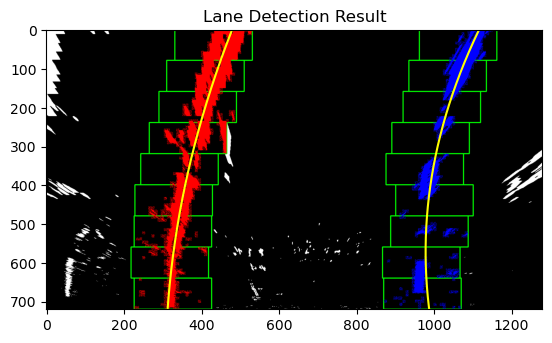

In [5]:
#Check based on windowing
binary_warped = cv2.imread('warped-example.jpg', cv2.IMREAD_GRAYSCALE)

# Call your lane detection and fitting functions
left_fit, right_fit, out_img = fit_polynomial(binary_warped)

# Plot the result
plt.imshow(out_img)
plt.title("Lane Detection Result")
plt.show()

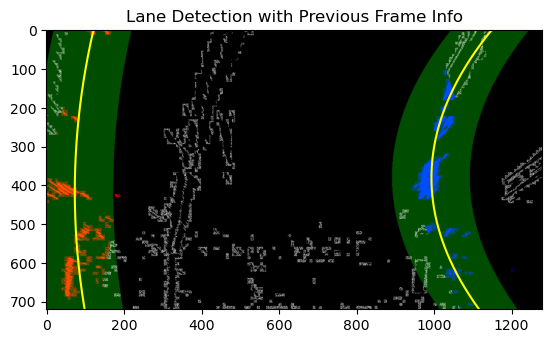

In [6]:
#Check based on previous frame
# Assume you have polynomial coefficients from a previous frame
prev_left_fit = [1e-4, -0.3, 200]
prev_right_fit = [1e-4, 0.3, 900]

# Use the search around poly method
left_fit, right_fit, out_img = search_around_poly(binary_warped, prev_left_fit, prev_right_fit)

# Plot the result
plt.imshow(out_img)
plt.title("Lane Detection with Previous Frame Info")
plt.show()

In [7]:
def measure_curvature_and_position(binary_warped, left_fit, right_fit):
    # Define conversions in x and y from pixels to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    
    # Calculate radius of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Calculate the position of the car
    lane_center = (left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2] +
                   right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]) / 2
    car_position = binary_warped.shape[1] / 2
    center_offset = (car_position - lane_center) * xm_per_pix

    return left_curverad, right_curverad, center_offset

# Measure curvature and position
left_curverad, right_curverad, center_offset = measure_curvature_and_position(binary_warped, left_fit, right_fit)
print(f"Left Curvature: {left_curverad:.2f} m")
print(f"Right Curvature: {right_curverad:.2f} m")
print(f"Center Offset: {center_offset:.2f} m")

Left Curvature: 1933.11 m
Right Curvature: 912.02 m
Center Offset: 0.17 m


In [8]:
def draw_lane(original_img, binary_warped, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting the lane line
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using the inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

    return result

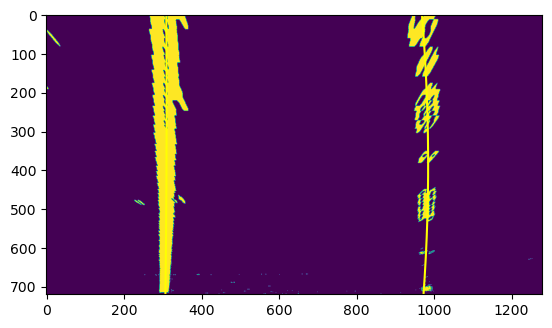

In [9]:
testImg = cv2.imread('TestImages/StraightLineTest1.jpg')
src, dst = define_perspective_transform(testImg)
undistorted_testImg = undistort_image(testImg, camera_matrix, dist_coeffs)
binary_warped, Minv = preprocess_image(testImg, camera_matrix, dist_coeffs, src, dst)
left_fit, right_fit, out_img = fit_polynomial(binary_warped)
plt.imshow(binary_warped)

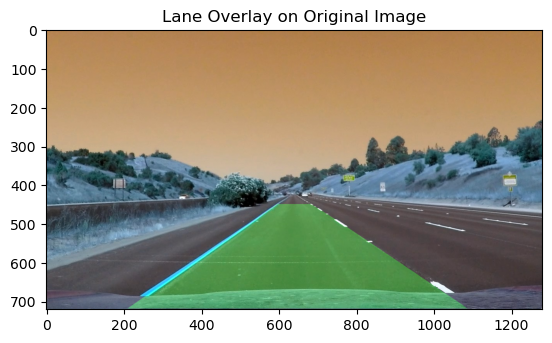

In [10]:
result = draw_lane(testImg, binary_warped, left_fit, right_fit, Minv)
plt.imshow(result)
plt.title('Lane Overlay on Original Image')
plt.show()

In [11]:
def process_frame(frame, camera_matrix, dist_coeffs, prev_left_fit=None, prev_right_fit=None):
    binary_warped, Minv = preprocess_image(frame, camera_matrix, dist_coeffs, src, dst)
    
    # Step 3: Lane detection (use previous fits if available)
    if prev_left_fit is None or prev_right_fit is None:
        left_fit, right_fit, out_img = fit_polynomial(binary_warped)
    else:
        left_fit, right_fit, out_img = search_around_poly(binary_warped, prev_left_fit, prev_right_fit)
        
    # Step 4: Calculate lane curvature and position
    left_curverad, right_curverad, center_offset = measure_curvature_and_position(binary_warped, left_fit, right_fit)

    # Step 5: Visualize lane overlay
    lane_overlay = draw_lane(frame, binary_warped, left_fit, right_fit, Minv)

    # Step 6: Annotate curvature and position on the frame
    curvature_text = f"Curvature: Left = {left_curverad:.2f}m, Right = {right_curverad:.2f}m"
    offset_text = f"Center Offset: {center_offset:.2f}m"
    cv2.putText(lane_overlay, curvature_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(lane_overlay, offset_text, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return lane_overlay, left_fit, right_fit



Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4



t:  80%|████████████████████████████████████████████████████▉             | 961/1199 [01:26<00:16, 14.82it/s, now=None]

Not enough points found in previous lane. Falling back to sliding window search.


Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4


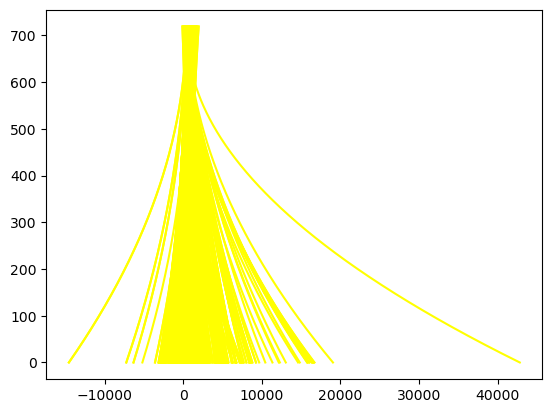

In [12]:
from moviepy.editor import VideoFileClip
# Process the video

def process_frame_with_tracking(frame):
    global prev_left_fit, prev_right_fit  # Keep track of previous fits

    # Process the current frame to detect the lane
    processed_frame, left_fit, right_fit = process_frame(frame, camera_matrix, dist_coeffs, prev_left_fit, prev_right_fit)

    # Update the previous fits with the newly detected fits for the next frame
    if left_fit is not None and right_fit is not None:
        prev_left_fit, prev_right_fit = left_fit, right_fit

    return processed_frame
    
def process_video(input_video, output_video, camera_matrix, dist_coeffs, src, dst):
    prev_left_fit, prev_right_fit = None, None  # Initialize previous fits

    # Load the input video
    video_clip = VideoFileClip(input_video)

    # Process each frame with lane tracking
    processed_clip = video_clip.fl_image(process_frame_with_tracking)

    # Write the processed video to the output
    processed_clip.write_videofile(output_video, audio=False)
    

# Example usage:
input_video = "harder_challenge_video.mp4"
output_video = "harder_challenge_video_output.mp4"    
video_clip = VideoFileClip(input_video)
processed_clip = video_clip.fl_image(process_frame_with_tracking)
processed_clip.write_videofile(output_video, audio=False)

In [13]:
# Call process_video with calibration data and perspective transform points (src and dst)
#process_video(input_video, output_video, camera_matrix, dist_coeffs, src, dst)